In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import gc

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from sklearn import tree
from imblearn.over_sampling import SMOTE

In [11]:
with open('data.csv') as f:
    lines = f.readlines()

In [12]:
lines

[',description,medical_specialty,sample_name,transcription,keywords\n',
 '0, A 23-year-old white female presents with complaint of allergies., Allergy / Immunology, Allergic Rhinitis ,"SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HE

# Loading Data

In [10]:
#reading the data in this cell and displaying it

clinical_text_df = pd.read_excel('data.xlsx', index_col=0)  
len(clinical_text_df)
print(clinical_text_df.columns)
clinical_text_df.head(450)


Index(['description', 'medical_specialty', 'sample_name', 'transcription',
       'keywords', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29',
       'Unnamed: 30', 'Unnamed: 31'],
      dtype='object')


description  ... Unnamed: 31
SNO                                                     ...            
0    A 23-year-old white female presents with compl...  ...         NaN
1             Consult for laparoscopic gastric bypass.  ...         NaN
2             Consult for laparoscopic gastric bypass.  ...         NaN
3                                 2-D M-Mode. Doppler.  ...         NaN
4                                   2-D Echocardiogram  ...         NaN
..                                                 ...  ...         ...
710  Incision and drainage of right buccal space ab...  ...         NaN
711  Placement of right external iliac artery cathe...  ...         NaN
713    Incision and drainage (I&D) of buttock abscess.  ...         NaN
716  Incision and drainage with bolster dressing pl...  ...         NaN
723  Left hydrocelectomy, cystopyelogram, bladder b...  ...         NaN

[450 rows x 31 columns]

In [4]:
 num_classes = len(clinical_text_df['medical_specialty'].unique())

In [5]:
num_classes

42

In [6]:
#cleaning the data, removing the null values
clinical_text_df = clinical_text_df[['description','medical_specialty','sample_name','transcription','keywords']]
clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]
text_df_transformers = clinical_text_df
clinical_text_df = clinical_text_df[clinical_text_df['description'].notna()]
clinical_text_df = clinical_text_df[clinical_text_df['keywords'].notna()]
len(clinical_text_df)

2995

# EDA



*   Visualizing the samples present for each medical speciality
*   Selecting only those specialities that have atleat 10 samples. Doing so will help the model generalise better to remaining categories and have enough samples to learn the features of ecah class better



number of specialties having less than 10 samples =  13


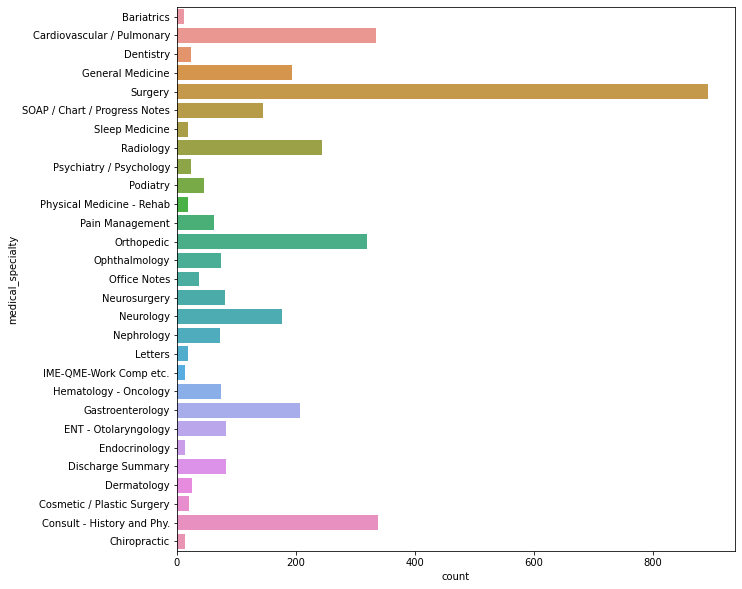

In [20]:
data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
i = 0
for catName,dataCategory in data_categories:
    if len(dataCategory) < 10:
      i += 1
print("number of specialties having less than 10 samples = ", i)
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 10) #filtering out categories that have <10 samples
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

# Data Pre-processing



*   Removing punctuation marks
*   Removing digits
*   Removing special characters
*   lowering the text
*   Stop words removal



In [49]:
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    specialCharacters = re.compile('[/(){}\[\]\|@,;]') 
    text2 = text1.lower()
    text2 = specialCharacters.sub('', text2)
    return text2

In [64]:
filtered_data_categories['transcription'] = filtered_data_categories['transcription'].apply(clean_text)
filtered_data_categories['description'] = filtered_data_categories['description'].apply(clean_text)
filtered_data_categories.head(2) #cleaned data

description  ...                                           keywords
SNO                                           ...                                                   
1    consult for laparoscopic gastric bypass  ...  bariatrics, laparoscopic gastric bypass, weigh...
2    consult for laparoscopic gastric bypass  ...  bariatrics, laparoscopic gastric bypass, heart...

[2 rows x 5 columns]

# Feature Creation

In order to train the model, we have to have feature set. Our feature set comprises of the "**description**" column in the dataset and the **"keywords"** column. Both the columns are combined and their combination is used as a feature to train the models.

In [65]:
filtered_data_categories['featureColumn'] = filtered_data_categories['description'] + " " + filtered_data_categories['keywords']

# Helper Functions

In [52]:
def embedData(featureName,dataset):
  '''
  Input - feature (text that has to be embedded)
  Output - embedded text 
  Functionality -  this funciton converts the given text into TF-IDF embeddings, capping off at vector length of 1000. 
  '''
  vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
  tfIdfMat  = vectorizer.fit_transform(dataset[featureName].tolist() )
  return tfIdfMat

In [51]:
def scatterPlot(tfidm,medical_specialty_classess):
  '''
  Input - embedded features
  Output - scatter plot for the embedded data  
  Functionality -
    1) this funciton takes in the embedded data (vector size of 1000),
    2) applies TSNE for dimensionality reduction of embeddings,
    3) reduces the data to two dimensions
    4) plots the reduced data as a scatter plot
  '''
  gc.collect()
  tfIdfMatrix = tfidm.todense()
  labels = filtered_data_categories['medical_specialty'].tolist()
  tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
  plt.figure(figsize=(16,10))
  palette = sns.hls_palette(medical_specialty_classess, l=.6, s=.9)
  sns.scatterplot(
      x=tsne_results[:,0], y=tsne_results[:,1],
      hue=labels,
      palette= palette,
      legend="full",
      alpha=0.3
  )
  plt.show()

In [54]:
def dimensionalityReduction(tfIdfMat,labels):
  '''
  Input - embedded features
  Output - reduced data matrix and reduced data split into train and test sets
  Functionality -
    1) this funciton takes in the embedded data (vector size of 1000),
    2) applies PCA for dimensionality reduction of embeddings,
  '''
  pca = PCA(n_components=0.95)
  tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
  X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)
  return [X_train, X_test, y_train,y_test,tfIdfMat_reduced]  

In [69]:
def classify(featureColumn, dataset, targetColumn,overSampling = False,overSamplingLoopIterations = 0):
    '''
    Input - name of the column that should be used as a fearure
    Output - trained muti class logistic regression model
    Functionality -
      1) this funciton takes in the name of the column that should be considered as a feature,
      2) applies TF-IDF embeddings to that column,
      3) performs dimensionality reduction using PCA
      4) prints the metrics for the classifier performance
    '''
    tfidm = embedData(featureColumn,dataset)
    num_classes = len(dataset[targetColumn].unique())
    classes = list(dataset[targetColumn].unique())
    labels = dataset[targetColumn].tolist()
    scatterPlot(tfidm,num_classes)
    X_train, X_test, y_train, y_test,reducedMatrix = dimensionalityReduction(tfidm,labels)

    if overSampling:
      smote_over_sample = SMOTE(sampling_strategy='minority')

      if overSamplingLoopIterations > 0:
        X, y = reducedMatrix, labels
        while overSamplingLoopIterations >0 :
          X, y = smote_over_sample.fit_resample(reducedMatrix, labels)
          overSamplingLoopIterations -= 1

        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)   

    
      
      #-----------------------
      #multi class logistic regression

    clf = LogisticRegression(
        penalty= 'elasticnet', 
        solver= 'saga', 
        l1_ratio=0.5, 
        random_state=1
    )
    clf.fit(X_train, y_train)  
    y_test_pred= clf.predict(X_test)
    print(classification_report(y_test,y_test_pred,labels=classes))

### Using 'transcription' column in the dataset to train and test the model.

The output consists of 


*   Scatter plot that describes distribution of the data based on the TF-IDF embeddings.

*   Confusion matrix describing the predictions obtained from the model

*   Classification metric report describing the accuracy of the model, precision, recall followed by a detailed breakdown with respect to every class of medical_speciality





Logistic regression multi class classification

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


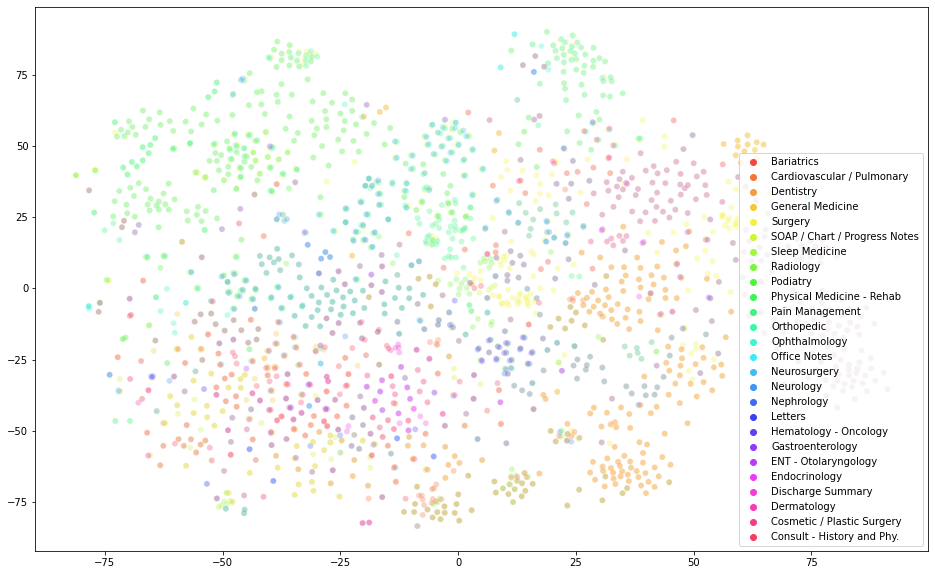

                               precision    recall  f1-score   support

                   Bariatrics       0.00      0.00      0.00         3
   Cardiovascular / Pulmonary       0.44      0.46      0.45        65
                    Dentistry       0.00      0.00      0.00         5
             General Medicine       0.28      0.17      0.21        29
                      Surgery       0.45      0.66      0.54       206
SOAP / Chart / Progress Notes       0.28      0.29      0.29        31
               Sleep Medicine       1.00      0.50      0.67         4
                    Radiology       0.38      0.47      0.42        58
                     Podiatry       0.00      0.00      0.00        10
    Physical Medicine - Rehab       0.00      0.00      0.00         3
              Pain Management       0.78      0.50      0.61        14
                   Orthopedic       0.29      0.30      0.30        70
                Ophthalmology       0.42      0.28      0.33        18
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
classify(
    featureColumn = 'transcription',
    dataset = filtered_data_categories,
    targetColumn = 'medical_specialty',
    )

### Using 'featureColumn' column in the dataset to train and test the model.

feature column is a combination of description and keywords.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


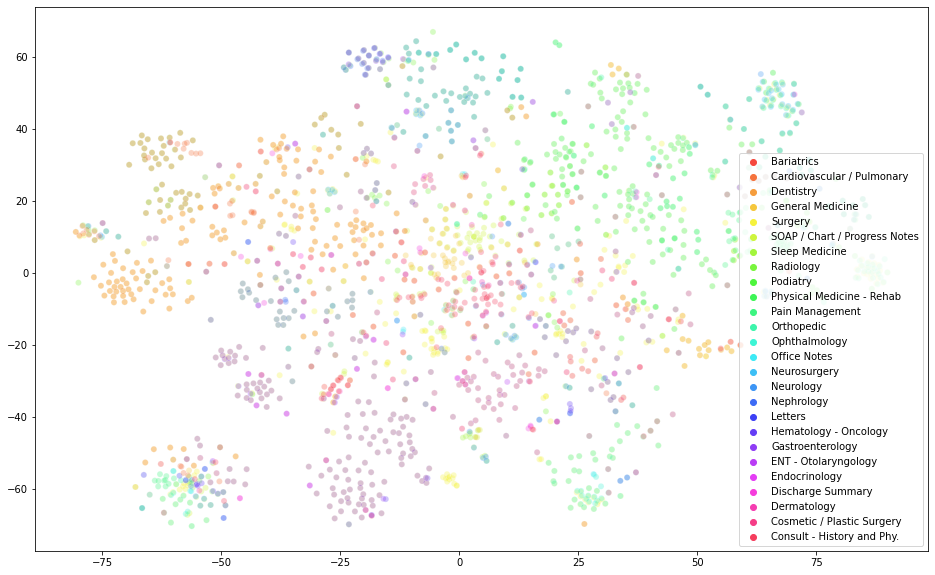

                               precision    recall  f1-score   support

                   Bariatrics       1.00      0.67      0.80         3
   Cardiovascular / Pulmonary       0.80      0.85      0.82        65
                    Dentistry       1.00      0.40      0.57         5
             General Medicine       0.96      0.86      0.91        29
                      Surgery       0.63      0.93      0.75       206
SOAP / Chart / Progress Notes       0.88      0.97      0.92        31
               Sleep Medicine       0.67      0.50      0.57         4
                    Radiology       0.80      0.71      0.75        58
                     Podiatry       0.40      0.20      0.27        10
    Physical Medicine - Rehab       0.00      0.00      0.00         3
              Pain Management       0.90      0.64      0.75        14
                   Orthopedic       0.71      0.86      0.78        70
                Ophthalmology       0.60      0.33      0.43        18
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
classify(
    featureColumn = 'featureColumn',
    dataset = filtered_data_categories,
    targetColumn = 'medical_specialty')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


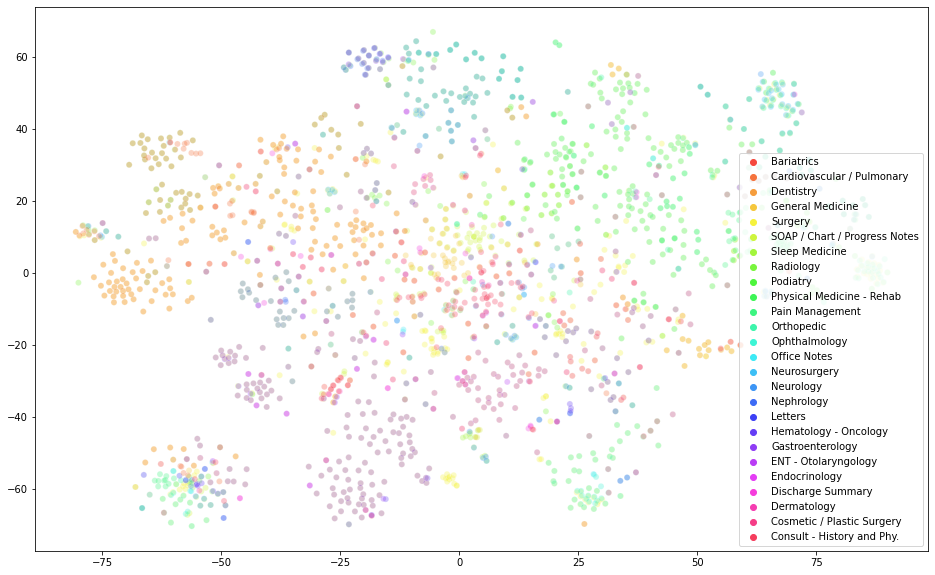

                               precision    recall  f1-score   support

                   Bariatrics       0.00      0.00      0.00         3
   Cardiovascular / Pulmonary       0.80      0.94      0.87        65
                    Dentistry       1.00      0.17      0.29         6
             General Medicine       0.96      0.86      0.91        29
                      Surgery       0.63      0.93      0.75       206
SOAP / Chart / Progress Notes       0.91      0.97      0.94        31
               Sleep Medicine       1.00      0.50      0.67         4
                    Radiology       0.83      0.68      0.75        57
                     Podiatry       1.00      0.30      0.46        10
    Physical Medicine - Rehab       0.97      1.00      0.99       206
              Pain Management       0.89      0.57      0.70        14
                   Orthopedic       0.73      0.91      0.81        70
                Ophthalmology       0.78      0.39      0.52        18
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
classify(
    featureColumn = 'featureColumn',
    dataset = filtered_data_categories,
    targetColumn = 'medical_specialty',
    overSampling = True,
    overSamplingLoopIterations = 4
    )

# Transformer based approach
Using transformer based model. I have made use of the RoBERTa model based on the BERT architecture for this task. It is a multi-class classification problem hence the BERT model has a single layer softmax classification layer on top of it. The classifcation layer makes use of the embeddings obtained from the BERT based model and classifies into different medical specialities. 

In [8]:
!pip install simpletransformers

     |████████████████████████████████| 247 kB 5.4 MB/s 
     |████████████████████████████████| 3.1 MB 37.2 MB/s 
     |████████████████████████████████| 9.1 MB 14.5 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 298 kB 47.0 MB/s 
     |████████████████████████████████| 3.3 MB 34.8 MB/s 
     |████████████████████████████████| 1.2 MB 34.7 MB/s 
     |████████████████████████████████| 1.7 MB 27.6 MB/s 
     |████████████████████████████████| 895 kB 35.4 MB/s 
     |████████████████████████████████| 61 kB 521 kB/s 
     |████████████████████████████████| 596 kB 43.1 MB/s 
     |████████████████████████████████| 180 kB 45.2 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 140 kB 45.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 132 kB 46.3 MB/s 
     |████████████████████████████████| 243 kB 47.9 MB/s 
     |█████████████████

In [21]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import torch

In [22]:
cuda_available = torch.cuda.is_available()

In [41]:
num_classes = len(filtered_data_categories['medical_specialty'].unique())
classes = list(filtered_data_categories['medical_specialty'].unique())
speciality_to_index = dict(zip(filtered_data_categories['medical_specialty'].unique(),list(range(num_classes))))
index_to_speciality = dict(zip(list(range(num_classes)),filtered_data_categories['medical_specialty'].unique()))
filtered_data_categories['medical_specialty'] = filtered_data_categories['medical_specialty'].apply(lambda x:speciality_to_index[x])

In [25]:
X = filtered_data_categories[['featureColumn']]
y = filtered_data_categories[["medical_specialty"]]
   
train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)
class_weights = [1]*num_classes

In [26]:
train_df = pd.DataFrame(columns=['text','labels'])
train_df['text'] = train_x['featureColumn']
train_df['labels'] = train_y['medical_specialty']
print(train_df.head())
test_df = pd.DataFrame(columns=['text','labels'])
test_df['text'] = test_x['featureColumn']
test_df['labels'] = test_y['medical_specialty']

                                                   text  labels
SNO                                                            
1970  lumbar epidural steroid injection ls low back ...      10
4769  holter monitor report cardiovascular / pulmona...       1
4590  patient status post gastric bypass surgery dev...      25
976   colonoscopy with photos the patient is an year...       4
566   sentinel lymph node biopsy ultrasoundguided lu...       4


In [27]:
learning_rate = 1e-5
num_of_epochs = 3
    
model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

model = ClassificationModel(
    "roberta",
    "roberta-base",
    num_labels=num_classes,
    weight=class_weights,
    use_cuda=cuda_available,
    args=model_args
    )

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [28]:
model.train_model(train_df)
model.save_model()
result, model_outputs, wrong_predictions = model.eval_model(test_df)

  0%|          | 0/2209 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/277 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/277 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/737 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/93 [00:00<?, ?it/s]

In [29]:
result,output = model.predict(test_df['text'].values.tolist())

  0%|          | 0/737 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

In [44]:
actual_labels = []
predicted_labels = []
for i in test_df['labels'].tolist():

  actual_labels.append(index_to_speciality[i]

for i in result:
  predicted_labels.append(index_to_speciality[i])

In [73]:
print(classification_report(actual_labels,predicted_labels,labels=classes))

                               precision    recall  f1-score   support

                   Bariatrics       0.00      0.00      0.00         3
   Cardiovascular / Pulmonary       1.00      1.00      1.00        65
                    Dentistry       1.00      1.00      1.00         5
             General Medicine       0.97      1.00      0.98        29
                      Surgery       1.00      1.00      1.00       206
SOAP / Chart / Progress Notes       1.00      1.00      1.00        31
               Sleep Medicine       1.00      0.75      0.86         4
                    Radiology       1.00      1.00      1.00        58
                     Podiatry       0.91      1.00      0.95        10
    Physical Medicine - Rehab       0.00      0.00      0.00         3
              Pain Management       0.82      1.00      0.90        14
                   Orthopedic       0.99      1.00      0.99        70
                Ophthalmology       0.95      1.00      0.97        18
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
